# Imports/Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path

%matplotlib inline

dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)

conn = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(os.getenv('DB_USER'),
                                                               os.getenv('DB_PASS'), 
                                                               os.getenv('DB_IP'), 
                                                               os.getenv('DB_PORT'), 
                                                               os.getenv('DB_NAME')))

# Download/Setup Data

In [2]:
dreampop_data = pd.read_sql("SELECT * FROM dreampop;", conn)
other_data = pd.read_sql("SELECT * FROM other;", conn)

In [3]:
#Combine data, drop non needed cols
data = dreampop_data.append(other_data, ignore_index=True)
data = data.drop(['index', 'type', 'uri', 'track_href', 'analysis_url'], axis=1)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre
0,0.420,0.330,9,-13.925,1,0.0275,0.24500,0.000679,0.0677,0.1750,157.143,1LzNfuep1bnAUR9skqdHCK,295600,3,Fade Into You,Mazzy Star,dreampop
1,0.512,0.838,0,-6.842,1,0.0310,0.01180,0.014200,0.1160,0.1950,117.992,1bwqV8EGVw1RLT3cEzxLpH,203390,4,Closer,Josha Daniel,dreampop
2,0.347,0.550,7,-9.048,1,0.0399,0.00419,0.049200,0.0992,0.0669,124.867,5TRSyGcFfevCbJHFUk4OB0,199680,4,Alive,Josha Daniel,dreampop
3,0.377,0.650,2,-5.902,1,0.0290,0.00174,0.000058,0.1070,0.3650,180.074,6sVQNUvcVFTXvlk3ec0ngd,192467,4,Cherry-coloured Funk,Cocteau Twins,dreampop
4,0.638,0.761,4,-7.945,0,0.1690,0.14700,0.000217,0.3210,0.3780,119.987,4uXWLG0CBQhJlvqPksiHxu,188000,4,High Enough,Lodola,dreampop


In [4]:
#Create genre ids
genres = list(data.groupby('genre').count().index)
genre_to_id = {}
id_to_genre = {}
for i, g in enumerate(genres):
    genre_to_id[g] = i
    genre_to_id[i] = g

In [5]:
#Map genres
data['genre_id'] = data['genre'].apply(lambda x: genre_to_id[x])
data['is_dreampop'] = data['genre'].apply(lambda x: True if x == 'dreampop' else False)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,artist,genre,genre_id,is_dreampop
0,0.605,0.480,0,-6.356,1,0.0285,0.00576,0.000073,0.1430,0.811,90.022,3OIoy3TNU7CL5PTaHOGmbR,222627,4,Espacio sideral,Jesse & Joy,latin,70,False
1,0.739,0.551,0,-7.640,1,0.0244,0.16100,0.001020,0.1230,0.455,95.058,62qI8m0sXpzlSjYYx0nZ83,287907,4,Si No Te Hubieras Ido,Marco Antonio Solís,latin,70,False
2,0.470,0.436,6,-13.103,1,0.0369,0.75700,0.000000,0.0776,0.583,67.133,0nh0R3e6HFynUAmL0ggV6x,254360,4,Kom änglar,Lars Winnerbäck,swedish,118,False
3,0.530,0.889,6,-4.252,1,0.3900,0.63800,0.000000,0.7060,0.619,74.778,7dhjddZIZXW7dngag77Uwm,151382,3,Thank You Jah,Vybz Kartel,dancehall,22,False
4,0.504,0.918,0,-3.463,1,0.0517,0.00164,0.000021,0.7800,0.539,92.031,5e3YOg6fIkP0wD5TyxcHOH,294827,4,Cult of Personality,Living Colour,hard-rock,49,False


# Create train, test, validate sets

In [6]:
data_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X = data[data_cols].to_numpy()
y = data['is_dreampop'].to_numpy().astype(int)
X.shape, y.shape

((20589, 13), (20589,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((12353, 13), (4118, 13), (4118, 13), (12353,), (4118,), (4118,))

# Classifiers

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_lr.score(X_test, y_test)

0.6148615832928606

## Naïve Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB().fit(X_train, y_train)
clf_nb.score(X_test, y_test)

0.6070908207867897

## Stochastic Gradient Descent

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf_sgd.fit(X_train, y_train)
clf_sgd.score(X_test, y_test)

0.6835842642059252

## K-Nearest Neighbours

In [11]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

0.5624089363768819

## Decision Tree

<ipython-input-12-7e60ad66b819>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


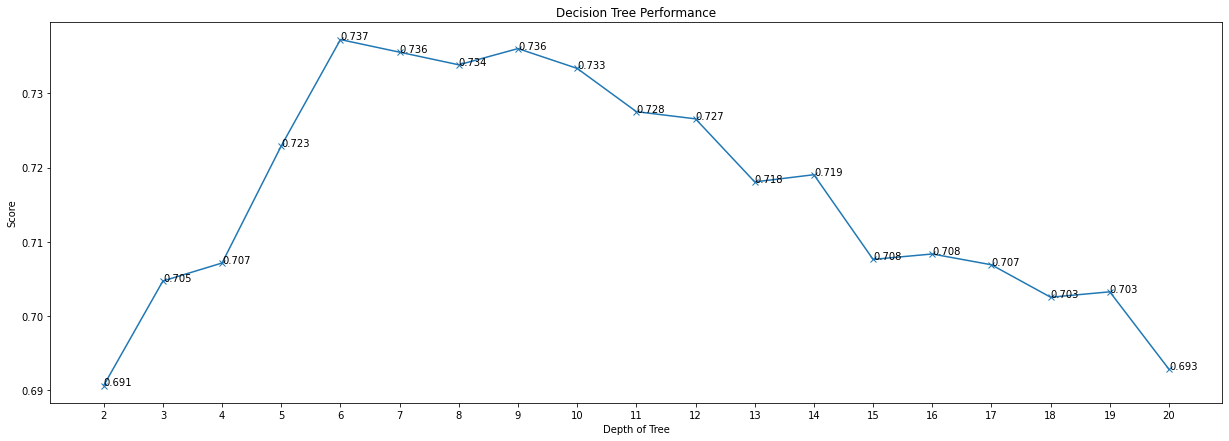

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

depths = list(range(2, 20 + 1))
scores = []
for d in depths:
    clf_dt = DecisionTreeClassifier(random_state=0, max_depth=d)
    clf_dt.fit(X_train, y_train)
    scores.append(clf_dt.score(X_test, y_test))

plt.figure(figsize=(21, 7))
plt.plot(depths, scores, '-x')
plt.xlabel('Depth of Tree')
plt.xticks(list(depths))
plt.ylabel('Score')
plt.title('Decision Tree Performance')
ax = plt.axes()
for i, v in enumerate(scores):
    ax.annotate(round(v, 3), (depths[i], scores[i]))
plt.show()

0.7372510927634774


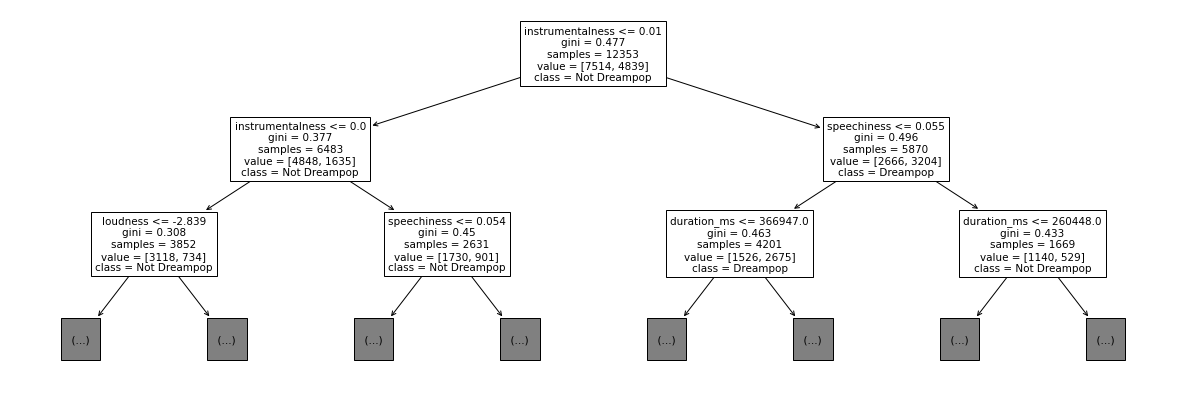

In [13]:
clf_dt = DecisionTreeClassifier(random_state=0, max_depth=scores.index(max(scores)) + 2)
clf_dt.fit(X_train, y_train)

plt.figure(figsize=(21, 7))
tree.plot_tree(clf_dt, feature_names=data_cols, class_names=['Not Dreampop', 'Dreampop'], max_depth=2)
clear_output()
print(clf_dt.score(X_test, y_test))

## Random Forest

<ipython-input-14-43b4ca638102>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


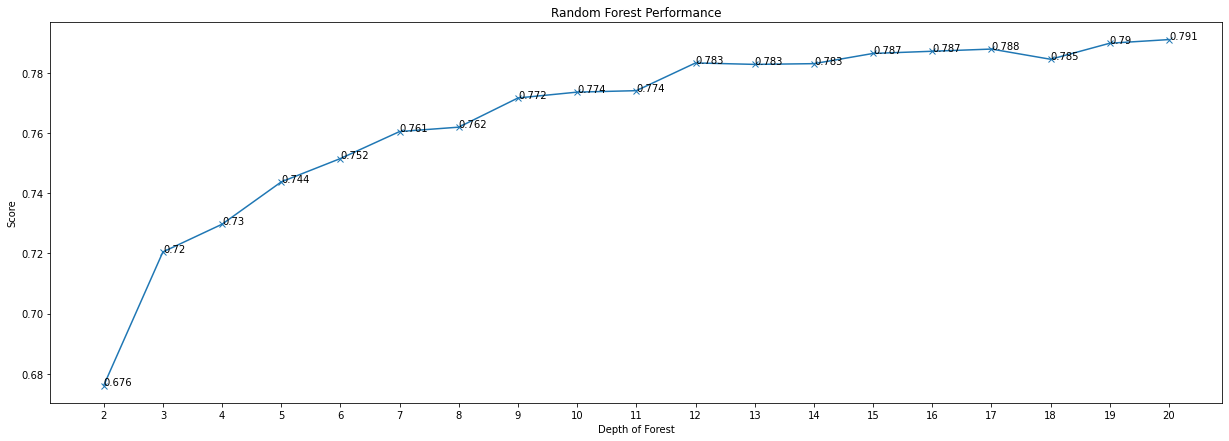

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

depths = list(range(2, 20 + 1))
scores = []
for d in depths:
    clf_rf = RandomForestClassifier(random_state=0, max_depth=d)
    clf_rf.fit(X_train, y_train)
    scores.append(clf_rf.score(X_test, y_test))

plt.figure(figsize=(21, 7))
plt.plot(depths, scores, '-x')
plt.xlabel('Depth of Forest')
plt.xticks(list(depths))
plt.ylabel('Score')
plt.title('Random Forest Performance')
ax = plt.axes()
for i, v in enumerate(scores):
    ax.annotate(round(v, 3), (depths[i], scores[i]))
plt.show()

In [15]:
clf_rf = RandomForestClassifier(max_depth=scores.index(max(scores)) + 2, random_state=0)
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

0.7911607576493443

## Support Vector Machine

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(X_train, y_train)
clf_svm.score(X_test, y_test)

0.7508499271491015

# Cross Validation

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

models = [clf_lr, clf_nb, clf_sgd, clf_knn, clf_dt, clf_rf, clf_svm]
names = ['clf_lr', 'clf_nb', 'clf_sgd', 'clf_knn', 'clf_dt', 'clf_rf', 'clf_svm']
scores = [[] for _ in models]

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        scores[i].append(model.score(X_test, y_test))

TRAIN: [    0     1     3 ... 20585 20586 20587] TEST: [    2     5     8 ... 20573 20575 20588]
TRAIN: [    0     1     2 ... 20586 20587 20588] TEST: [   10    11    12 ... 20576 20578 20584]
TRAIN: [    0     1     2 ... 20586 20587 20588] TEST: [    3    16    19 ... 20577 20579 20581]
TRAIN: [    0     1     2 ... 20584 20587 20588] TEST: [    4     6    15 ... 20582 20585 20586]
TRAIN: [    2     3     4 ... 20585 20586 20588] TEST: [    0     1     7 ... 20562 20583 20587]


In [18]:
scores = [np.mean(score) for score in scores]
sorted(list(zip(names, scores)), key=lambda x: x[1], reverse=True)

[('clf_rf', 0.7945021194650924),
 ('clf_svm', 0.7504007064844318),
 ('clf_dt', 0.7284475356153066),
 ('clf_sgd', 0.6738554163000332),
 ('clf_lr', 0.6083831677677567),
 ('clf_nb', 0.5871588243961268),
 ('clf_knn', 0.5771047161917506)]